In [1]:
"""
FOR TESTING PURPOSES
"""
%load_ext autoreload
%autoreload 2

In [229]:
"""
Import relevant modules
"""

import pathlib

import SimpleITK as sitk
import numpy as np

from platipy.imaging.registration.registration import apply_field

from platipy.imaging.visualisation.tools import ImageVisualiser, project_onto_arbitrary_plane, generate_animation_from_image_sequence

from platipy.imaging.utils.tools import label_to_roi, get_com

from platipy.imaging.tests.pull_data import get_lung_data

"""
Deformation field operations
"""
from platipy.imaging.deformation_fields.deformation_field_operations import (
get_bone_mask,
get_external_mask,
generate_field_shift,
generate_field_asymmetric_contract,
generate_field_asymmetric_extend,
generate_field_expand
)

%matplotlib notebook

Traceback (most recent call last):
  File "/home/robbie/Software/Anaconda/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/robbie/Software/Anaconda/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [3]:
"""
Download a sample case
"""
get_lung_data(number_of_patients=1)

2020-12-20 19:37:35.118 | DEBUG    | platipy.imaging.tests.pull_data:fetch_data:117 - Path exists: /home/robbie/Work/4_Software/platipy/platipy/imaging/tests/data/LCTSC/LCTSC-Test-S1-101, won't fetch data


{'LCTSC-Test-S1-101': '/home/robbie/Work/4_Software/platipy/platipy/imaging/tests/data/LCTSC/LCTSC-Test-S1-101'}

In [4]:
"""
Read in some images and structures for this demonstration
We are using a lung radiotherapy dataset comprising CT and RTSTRUCT
"""

image_ct = sitk.ReadImage("../../imaging/tests/data/LCTSC/LCTSC-Test-S1-101/CT.nii.gz")

structure_list = ["Heart", "Esophagus", "Lung_L", "Lung_R", "SpinalCord"]
label_images = {i:sitk.ReadImage(f"../../imaging/tests/data/LCTSC/LCTSC-Test-S1-101/Struct_{i}.nii.gz") for i in structure_list}

In [5]:
"""
Deformation 1: SHIFTING SPECIFIC STRUCTURES

We define a vector shift and then apply smoothing for more realistic deformation.
We use a bone mask to keep bony anatomy consistent.
"""

label_shift, shift_transform, shift_dvf = generate_field_shift(label_images["Heart"], vector_shift=(-20,-20,10), gaussian_smooth=20)

# label_images_shifted = {i:sitk.ReadImage(f"../../imaging/tests/data/LCTSC/LCTSC-Test-S1-101/Struct_{i}.nii.gz") for i in structure_list}

In [6]:
"""
We can apply the transformation to the image, or to the other structures
"""

image_ct_deformed = apply_field(image_ct, shift_transform, structure=False, default_value=-1000)

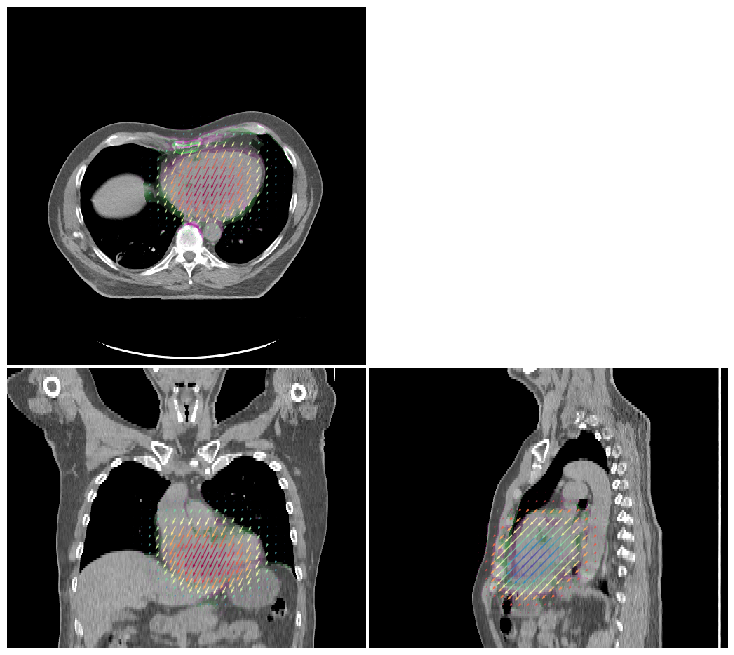

In [7]:
"""
One way to display is to overlay the images and vector field
"""
vis = ImageVisualiser(image=image_ct, cut=get_com(label_shift), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(shift_dvf, arrow_scale=1, subsample=(4,12,12))

fig = vis.show()

No contour levels were found within the data range.
The following kwargs were not used by contour: 'label'


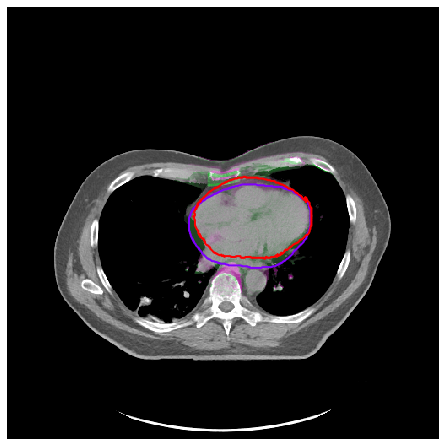

In [8]:
"""
Another method is displaying both the original and deformed image with contours
"""

vis = ImageVisualiser(image = image_ct, axis='z', cut=50, figure_size_in=6)
vis.add_comparison_overlay(image_ct_deformed)
vis.add_contour({"heart":label_images["Heart"], "heart (shifted)":label_shift})
fig = vis.show()


In [9]:
"""
These methods are widely applicable to other deformations
There are a few available:
    generate_field_shift
    generate_field_asymmetric_contract
    generate_field_asymmetric_extend
    generate_field_expand

Each of these will be demonstrated below, with some notes

"""

'\nThese methods are widely applicable to other deformations\nThere are a few available:\n    generate_field_shift\n    generate_field_asymmetric_contract\n    generate_field_asymmetric_extend\n    generate_field_expand\n\nEach of these will be demonstrated below, with some notes\n\n'

In [68]:
"""
generate_field_asymmetric_contract

This function takes a structure and contracts in each dimension individually (axial, coronal, sagittal).
This contraction can be either positive of negative to define which side of the structure undergoes contraction:
    (+/-, +/-, +/-) = contract volume at (inf/sup, post/ant, r/l) border in patient coordinates.
"""

label_contract, contract_transform, contract_dvf = generate_field_asymmetric_contract(label_images["Lung_L"]+label_images["Lung_R"], vector_asymmetric_contract=(-30,15,0), gaussian_smooth=10, return_mask=True, return_transform=True)

image_ct_deformed = apply_field(image_ct, contract_transform, structure=False, default_value=-1000)

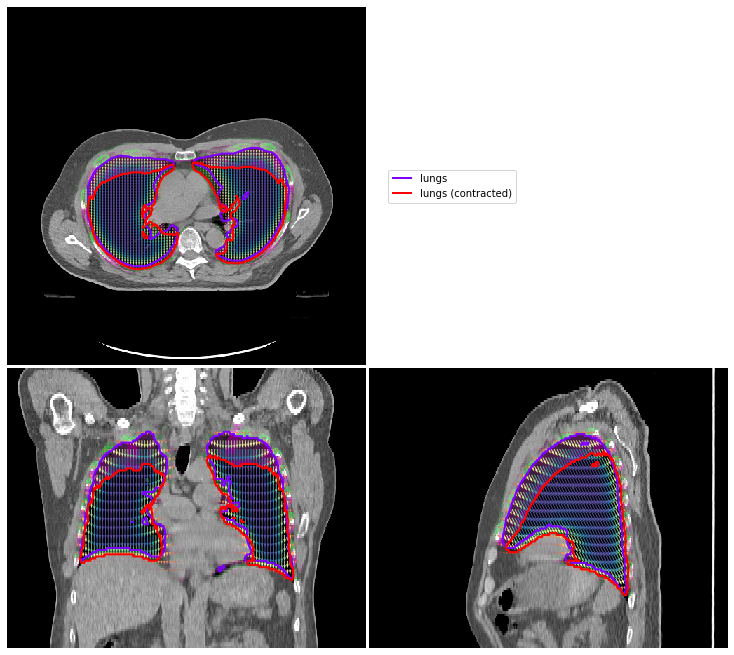

In [70]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Lung_L"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(contract_dvf, arrow_scale=0.5, subsample=4, color_function='magnitude')
vis.add_contour({"lungs":label_images["Lung_L"]+label_images["Lung_R"], "lungs (contracted)":label_contract})

fig = vis.show()

In [73]:
"""
generate_field_asymmetric_extend

This function takes a structure and extends in each dimension individually (axial, coronal, sagittal).
This extendion can be either positive of negative to define which side of the structure undergoes extendion:
    (+/-, +/-, +/-) = extend volume at (sup/inf, ant/post, l/r) border in patient coordinates.
"""

label_extend, extend_transform, extend_dvf = generate_field_asymmetric_extend(label_images["Lung_L"]+label_images["Lung_R"], vector_asymmetric_extend=(-30, 0, 0), gaussian_smooth=10, return_mask=True, return_transform=True)

image_ct_deformed = apply_field(image_ct, extend_transform, structure=False, default_value=-1000)

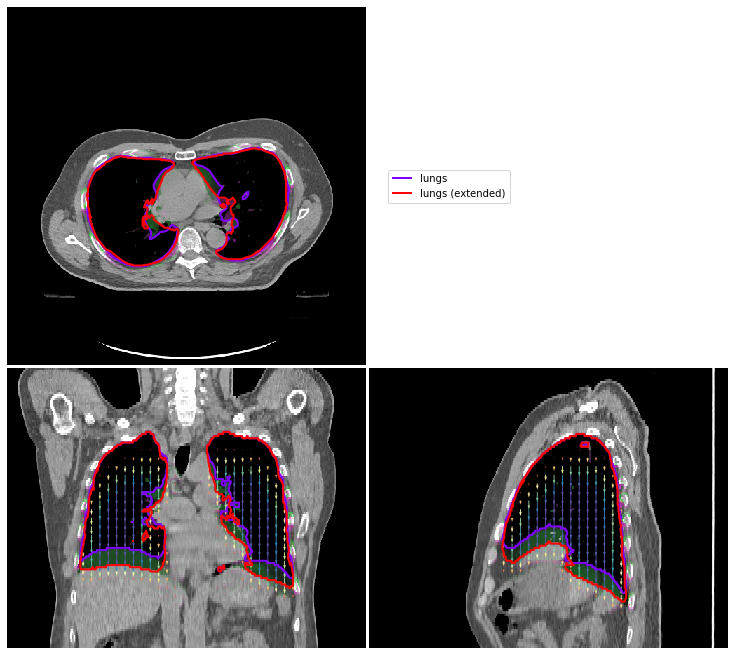

In [75]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Lung_L"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(extend_dvf, arrow_scale=0.5, subsample=(4,12,12), color_function='magnitude')
vis.add_contour({"lungs":label_images["Lung_L"]+label_images["Lung_R"], "lungs (extended)":label_extend})

fig = vis.show()

In [83]:
"""
generate_field_expand

This function takes a structure and expands or shrinks the structure.
The variable *expand* defines the expansion (or shrinking) in mm.
It can also be defined as a 3D vector, in which case the expansion is anisotropic.

Note - simultaneous expansion/shrinking in different directions is not yet supported!
"""

label_expand, expand_transform, expand_dvf = generate_field_expand(label_images["Heart"], bone_mask=False, expand=10, gaussian_smooth=5, return_mask=True, return_transform=True)

image_ct_deformed = apply_field(image_ct, expand_transform, structure=False, default_value=-1000)

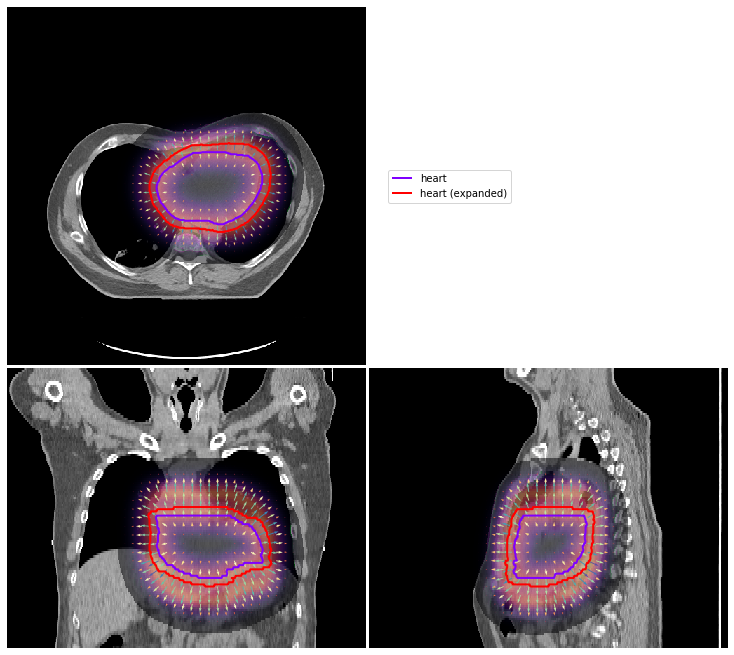

In [97]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Heart"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_scalar_overlay(sitk.VectorMagnitude(expand_dvf), colormap=plt.cm.magma, alpha=0.5)
vis.add_vector_overlay(expand_dvf, arrow_scale=1, subsample=(4,12,12), color_function='magnitude')
vis.add_contour({"heart":label_images["Heart"], "heart (expanded)":label_expand})

fig = vis.show()

In [263]:
angle_list = np.linspace(0, np.pi*2, 50)
image_list = []
contour_list = []
scalar_list = []

for angle in angle_list:
    im_rotate = project_onto_arbitrary_plane(
        image_ct,
        projection_name='mean',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1
    )
    image_list.append(im_rotate)
    
    contour_rotate_lung_l = project_onto_arbitrary_plane(
        label_images["Lung_L"],
        projection_name='max',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    contour_rotate_lung_r= project_onto_arbitrary_plane(
        label_images["Lung_R"],
        projection_name='max',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    contour_list.append({"LUNG L": contour_rotate_lung_l, "LUNG R": contour_rotate_lung_r})
    
    scalar_rotate =  project_onto_arbitrary_plane(
        label_images["Heart"],
        projection_name='mean',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    scalar_list.append(scalar_rotate)

In [276]:
animation = generate_animation_from_image_sequence(image_list, contour_list=contour_list, scalar_list=scalar_list, scalar_alpha=1, scalar_min=0.01, fps=12.5)

<IPython.core.display.Javascript object>

No contour levels were found within the data range.
No contour levels were found within the data range.
MovieWriter stderr:
convert: unexpected end-of-file `-': No such file or directory @ error/rgb.c/ReadRGBImage/239.



CalledProcessError: Command '['/usr/bin/convert', '-size', '600x468', '-depth', '8', '-delay', '8.0', '-loop', '0', 'rgba:-', 'animation.gif']' returned non-zero exit status 1.

In [ ]:
"""
generate_field_radial_bend


"""

label_expand, expand_transform, expand_dvf = generate_field_expand(label_images["Heart"], bone_mask=False, expand=10, gaussian_smooth=5, return_mask=True, return_transform=True)

image_ct_deformed = apply_field(image_ct, expand_transform, structure=False, default_value=-1000)

In [ ]:
fig, ax